In [1]:
!pip install torch torchvision torchaudio openai-clip scikit-learn pillow

  Using cached torchaudio-2.2.2-cp312-cp312-macosx_10_13_x86_64.whl.metadata (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Using cached torchaudio-2.2.2-cp312-cp312-macosx_10_13_x86_64.whl (3.4 MB)
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368631 sha256=9c94c227e6b60caff45330dfbace34de3bb3db8bd434ef6ef05d460735488faf
  Stored in directory: /Users/opam/Library/Caches/pip/wheels/ab/49/bc/c2342e8e14878210ba4825cf314a53f2570f6fb18b91fce3cf
Successfully built openai-clip


In [9]:
import pandas as pd
import torch
import clip
from PIL import Image
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

ds = pd.read_csv("./data/pp_sneaks.csv")

In [11]:
# Load CLIP Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Store image and text features
img_feats = []
txt_feats = []

print("Extracting image features...")
for img_path in tqdm(ds["img_path"].tolist(), desc="Processing images"):
    full_path = os.path.join("feetflix", os.path.basename(img_path))
    try:
        img = preprocess(Image.open(full_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            feats = model.encode_image(img).cpu().numpy().squeeze()
            feats = feats / np.linalg.norm(feats)  # L2 Normalize embeddings
        img_feats.append(feats)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        img_feats.append(np.random.normal(0, 0.01, (512,)))  # Small noise instead of zeros

ds["img_feats"] = img_feats

print("Extracting text features...")
for item in tqdm(ds["item"].tolist(), desc="Processing text"):
    text_tokens = clip.tokenize([item]).to(device)
    with torch.no_grad():
        text_feature = model.encode_text(text_tokens).cpu().numpy().squeeze()
        text_feature = text_feature / np.linalg.norm(text_feature)  # L2 Normalize
    txt_feats.append(text_feature)

ds["txt_feats"] = txt_feats

# Convert features to NumPy arrays
img_feats_np = np.array(img_feats)
txt_feats_np = np.array(txt_feats)

# Standardize numeric values to prevent biases
scaler = StandardScaler()
ds[["retail", "lowestAsk", "highestBid"]] = scaler.fit_transform(ds[["retail", "lowestAsk", "highestBid"]])

def weighted_similarity(image_feature):
    """
    Find the best match for a given image feature using weighted similarity.
    """
    # Ensure correct shape
    image_feature = image_feature.reshape(1, -1)

    # Compute cosine similarity
    similarities = cosine_similarity(image_feature, txt_feats_np).flatten()

    # Normalize numeric values
    price_weight = ds["retail"]
    ask_weight = ds["lowestAsk"]
    bid_weight = ds["highestBid"]

    # Apply softmax to cosine similarity for stable ranking
    exp_sim = np.exp(similarities - np.max(similarities))
    norm_similarities = exp_sim / np.sum(exp_sim)

    # Adjust weight distribution (Focus more on image-text similarity)
    similarity_score = (
        (norm_similarities * 0.9) +  # 90% weight for image-text similarity
        (price_weight * 0.03) +  # 3% weight for retail price similarity
        (ask_weight * 0.03) +  # 3% weight for lowest ask price similarity
        (bid_weight * 0.04)  # 4% weight for highest bid price similarity
    )

    # Get best matches
    best_match_indices = np.argsort(similarity_score)[::-1][:3]  # Get top 3 matches
    return ds.iloc[best_match_indices]

# Debugging: Check first 5 results and print top 3 matches
for i in range(5):
    sample_img_feats = img_feats_np[i]
    best_matches = weighted_similarity(sample_img_feats)

    print(f"🔍 Image {i+1} | Actual: {ds.iloc[i]['item']}")
    print(f"🥇 Top 1: {best_matches.iloc[0]['item']} (Similarity: {cosine_similarity(sample_img_feats.reshape(1, -1), txt_feats_np[best_matches.index[0]].reshape(1, -1))[0][0]:.3f})")
    print(f"🥈 Top 2: {best_matches.iloc[1]['item']} (Similarity: {cosine_similarity(sample_img_feats.reshape(1, -1), txt_feats_np[best_matches.index[1]].reshape(1, -1))[0][0]:.3f})")
    print(f"🥉 Top 3: {best_matches.iloc[2]['item']} (Similarity: {cosine_similarity(sample_img_feats.reshape(1, -1), txt_feats_np[best_matches.index[2]].reshape(1, -1))[0][0]:.3f})")
    print("="*60)


Extracting image features...


Processing images: 100%|██████████| 2000/2000 [03:01<00:00, 11.00it/s]


Extracting text features...


Processing text: 100%|██████████| 2000/2000 [02:00<00:00, 16.57it/s]

🔍 Image 1 | Actual: Jordan 4 Retro SB Pine Green
🥇 Top 1: Jordan 4 Retro Off-White Sail (W) (Similarity: 0.275)
🥈 Top 2: Jordan 1 Retro High Off-White University Blue (Similarity: 0.182)
🥉 Top 3: Jordan 1 Retro High Travis Scott (Similarity: 0.148)
🔍 Image 2 | Actual: Jordan 3 Retro White Cement Reimagined
🥇 Top 1: Jordan 4 Retro Off-White Sail (W) (Similarity: 0.295)
🥈 Top 2: Jordan 1 Retro High Off-White University Blue (Similarity: 0.198)
🥉 Top 3: Jordan 1 Retro High Travis Scott (Similarity: 0.168)
🔍 Image 3 | Actual: Nike Air Force 1 Low Tiffany & Co. 1837
🥇 Top 1: Jordan 4 Retro Off-White Sail (W) (Similarity: 0.128)
🥈 Top 2: Jordan 1 Retro High Off-White University Blue (Similarity: 0.234)
🥉 Top 3: Jordan 1 Retro High Travis Scott (Similarity: 0.218)
🔍 Image 4 | Actual: Nike Air Max 1 '86 Big Bubble Sport Red
🥇 Top 1: Jordan 4 Retro Off-White Sail (W) (Similarity: 0.239)
🥈 Top 2: Jordan 1 Retro High Off-White University Blue (Similarity: 0.192)
🥉 Top 3: Jordan 1 Retro High Travi

In [4]:
valid_feats = sum(1 for feat in img_feats if np.any(feat))
print(f"extracted feats for {valid_feats}/{len(img_feats)} images.")

extracted feats for 2000/2000 images.


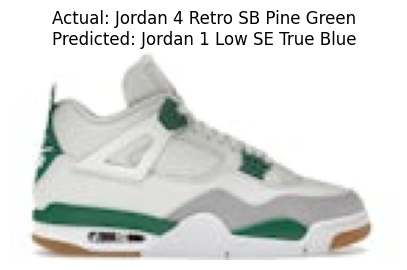

✅ Image 1: Matched Jordan 1 Low SE True Blue (Actual: Jordan 4 Retro SB Pine Green)



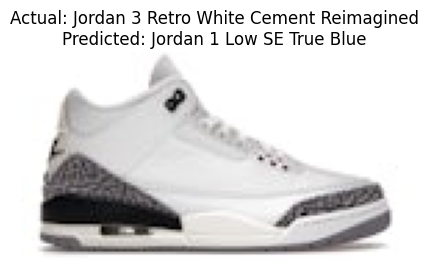

✅ Image 2: Matched Jordan 1 Low SE True Blue (Actual: Jordan 3 Retro White Cement Reimagined)



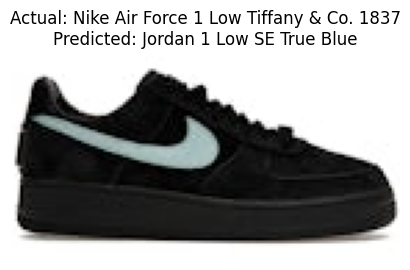

✅ Image 3: Matched Jordan 1 Low SE True Blue (Actual: Nike Air Force 1 Low Tiffany & Co. 1837)



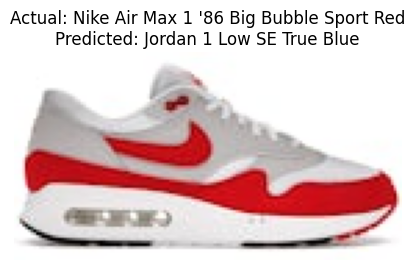

✅ Image 4: Matched Jordan 1 Low SE True Blue (Actual: Nike Air Max 1 '86 Big Bubble Sport Red)



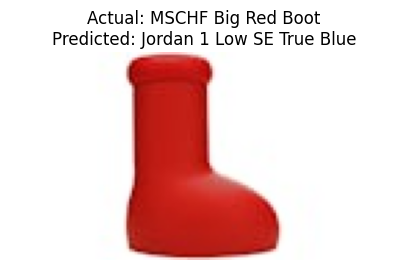

✅ Image 5: Matched Jordan 1 Low SE True Blue (Actual: MSCHF Big Red Boot)



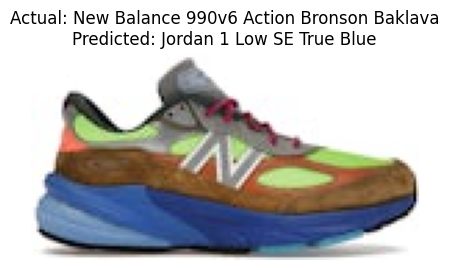

✅ Image 6: Matched Jordan 1 Low SE True Blue (Actual: New Balance 990v6 Action Bronson Baklava)



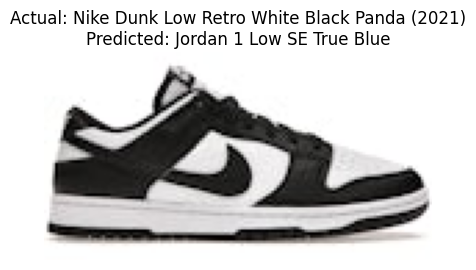

✅ Image 7: Matched Jordan 1 Low SE True Blue (Actual: Nike Dunk Low Retro White Black Panda (2021))



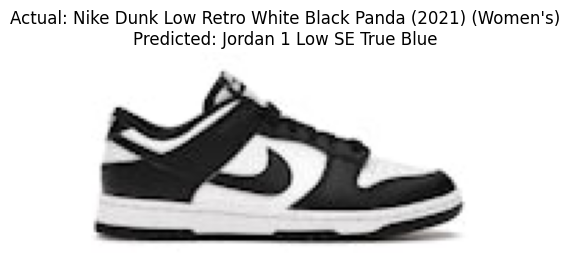

✅ Image 8: Matched Jordan 1 Low SE True Blue (Actual: Nike Dunk Low Retro White Black Panda (2021) (Women's))



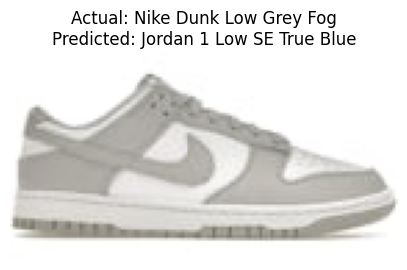

✅ Image 9: Matched Jordan 1 Low SE True Blue (Actual: Nike Dunk Low Grey Fog)



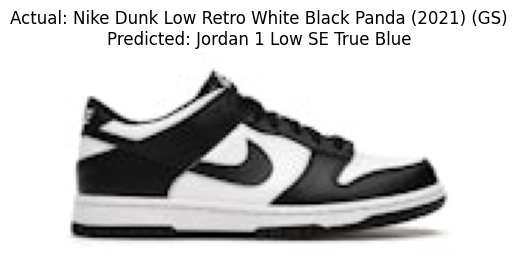

✅ Image 10: Matched Jordan 1 Low SE True Blue (Actual: Nike Dunk Low Retro White Black Panda (2021) (GS))



In [7]:
import matplotlib.pyplot as plt

# Iterate through multiple images and check their predictions
for i in range(10):  # Check the first 10 images
    sample_image_feature = img_feats_np[i]
    closest_match = weighted_similarity(sample_image_feature)

    # Retrieve actual and predicted sneaker names
    actual_sneaker = ds.iloc[i]["item"]
    predicted_sneaker = closest_match["item"]

    # Get image path
    img_path = ds.iloc[i]["img_path"]
    img_full_path = os.path.join("feetflix", os.path.basename(img_path))

    try:
        # Load and display image
        image = Image.open(img_full_path)
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Actual: {actual_sneaker}\nPredicted: {predicted_sneaker}")
        plt.show()

        # Print to console for logging
        print(f"✅ Image {i+1}: Matched {predicted_sneaker} (Actual: {actual_sneaker})\n")

    except Exception as e:
        print(f"⚠️ Error displaying image {img_path}: {e}")
